## Run Figure 8 (or 2 Ellipses)

This Notebook contains codes to run a robot in circles.

In [10]:
import os
import pickle
import cv2
import numpy as np
import math
import time
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import display
import ipywidgets.widgets as widgets
from jetbot import bgr8_to_jpeg
from jetbot import ObjectDetector
from jetbot import Camera
from jetbot import Robot

robot = Robot()

In [3]:
# Mapping between set_motor "speed" and measured wheel angular velocity "omega"
# for 0.1 second motor running time
wheel_calibration = {
    "speed": [0.25, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8],
    "omega": [0.0, 3.85, 9.23, 15.0, 25.8, 29.2, 35.4]
}

In [8]:
def forward(wheel_speed, Rtime):

    robot.set_motors(wheel_speed, wheel_speed)
    time.sleep(Rtime)
    robot.stop()
    
    return

def control2robot(wheel_radius, axle_length):
    """ transform wheel speeds to robot motion in world frame """
    l = axle_length
    r = wheel_radius

    return np.array([[r/2, r/2],
                  [r/l, -r/l]])

def omega2speed(in_val, mapping):
    """ Map wheel angular speed to motor speed setting based on a calibration mapping """
    
    if in_val < 0:
        sign = -1
        in_val = abs(in_val)
    else:
        sign = 1
        
    out_lower = 0
    in_lower = 0
    out_val = 0

    for i, in_upper in enumerate(mapping["omega"]):
        print (i, in_upper)
        if in_val < in_upper:
            out_upper = mapping["speed"][i]
            out_val = out_lower + (in_val - in_lower)/(in_upper - in_lower) \
                *(out_upper-out_lower)
            print("yes", out_val)
            break
        else:
            print("no")
            out_lower = mapping["speed"][i]
            in_lower = in_upper
            
    if out_val is 0:
        print ("Input is too high!!!", in_val)
        out_val = 0
        
    return sign*out_val


def calc_wheel_velocities(direction='L', arc_radius=0.5, min_ang_vel=3.85, \
       wheel_radius=0.0325, axle_length=0.12, debug = False):
    """ Calculate wheel velocities to generate forward arc motion of provided radius """

    radius = arc_radius
    axle = axle_length
    
    if direction is 'L':
        """ If left turn, angular velocity of right wheel should be higher.
        Set angular velocity of left wheel to minumum (e.g. 3.85--> motor setting of 0.3) """
        l_ang_vel = min_ang_vel
        r_ang_vel = (min_ang_vel*2)/(2*radius/axle-1)+min_ang_vel
    else:
        """ If right turn, angular velocity of left wheel should be higher.
        Set angular velocity of right wheel to minumum (e.g. 3.85--> motor setting of 0.3) """
        r_ang_vel = min_ang_vel    
        l_ang_vel = (min_ang_vel*2)/(2*radius/axle-1)+min_ang_vel
    
    if debug:
        print ("Left angular velocity:",l_ang_vel, " Right angular velocity:",r_ang_vel)
        T = control2robot(wheel_radius, axle_length)
        robot_velocities = np.dot(T, np.array([[r_ang_vel],[l_ang_vel]]))
        print ("Robot velocities:", robot_velocities)
        print("arc radius = ",abs(robot_velocities[0,0]/robot_velocities[1,0]))
    
    return np.array([[r_ang_vel],[l_ang_vel]])

def robot_pose_delta(v,w,theta,dt):
    """ Calculate change in robot pose in world frame """
    
    """ An alternate way - can avoid divide by zero error if w is zero
    x_delta = v*dt*math.cos(theta)
    y_delta = v*dt*math.sin(theta)
    """
    arc_radius = v/w   # arc radius
    
    x_delta = arc_radius*(math.sin(theta+w*dt)-math.sin(theta))
    y_delta = arc_radius*(math.cos(theta)-math.cos(theta+w*dt))
    theta_delta = w*dt
    
    return x_delta, y_delta, theta_delta


In [22]:
forward(0.8, 0.1)

In [2]:
robot.set_motors(0.3, 0.25)

In [3]:
robot.stop()

In [5]:
robot_params = {
    "start_x": 0.75,
    "start_y": 0.75,
    "wheel_radius": 0.0325,
    "axle_length": 0.12,
    "ang_velocity": 3.846 # Equivalent to motor speed setting of 0.3
}

In [7]:
def take_circ_step(robot_params, direction, radius, debug=False, motion=True):
    
    # load robot control parameters
    wheel_radius = robot_params["wheel_radius"]
    axle_length = robot_params["axle_length"]
    motor_on_time = robot_params["motor_on_time"]
    motor_off_time = robot_params["motor_off_time"]
    min_ang_velocity = robot_params["min_ang_velocity"]
    
    """ Generate clamped wheel velocities based on turn direction and radius """
    wheel_velocities = calc_wheel_velocities(direction='L', arc_radius=radius, \
        min_ang_vel=min_ang_velocity, \
        wheel_radius=wheel_radius, axle_length=axle_length, debug = debug)
    
    """ Map wheel angular velocities to motor setting, then run motors """ 
    w_r = omega2speed(wheel_velocities[0,0],wheel_calibration) 
    w_l = omega2speed(wheel_velocities[1,0],wheel_calibration)
    if debug:
        print ("L motor:", w_l," R motor:", w_r)
    
    """ Run motor step motion """
    if motion:
        robot.set_motors(w_l, w_r)  # left, right
        time.sleep(motor_on_time)
        robot.stop()
        time.sleep(motor_off_time)
    
    return wheel_velocities

In [ ]:
for i in range(100):
    take_circ_step(robot_params, 'L', 0.4, debug=True)

In [69]:
x_s =[]
y_s = []

a = 60
b = 30

c_x = 75
c_y = 105

x = 75
y = 75
theta = -math.pi/2

x_s.append(x)
y_s.append(y)

for i in range(51):
    theta = -math.pi/2 + 2*math.pi/100*i
    prev_x = x
    prev_y = y
    x = c_x+a*math.cos(theta)
    y = c_y+b*math.sin(theta)
    
    
    x_s.append(x)
    y_s.append(y)



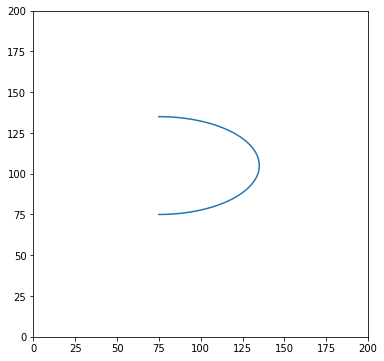

In [71]:
plt.figure(figsize=(6,6))
plt.xlim([0,200])
plt.ylim([0,200])
plt.plot(x_s,y_s)
plt.show()
plt.close()

In [51]:
x_s

[6.266661678215213,
 6.266661678215213,
 6.266661678215213,
 6.266661678215213,
 6.266661678215213,
 6.266661678215213,
 6.266661678215213,
 6.266661678215213,
 6.266661678215213,
 6.266661678215213,
 6.266661678215213,
 6.266661678215213,
 6.266661678215213,
 6.266661678215213,
 6.266661678215213,
 6.266661678215213,
 6.266661678215213,
 6.266661678215213,
 6.266661678215213,
 6.266661678215213,
 6.266661678215213,
 6.266661678215213,
 6.266661678215213,
 6.266661678215213,
 6.266661678215213,
 6.266661678215213,
 6.266661678215213,
 6.266661678215213,
 6.266661678215213,
 6.266661678215213,
 6.266661678215213,
 6.266661678215213,
 6.266661678215213,
 6.266661678215213,
 6.266661678215213,
 6.266661678215213,
 6.266661678215213,
 6.266661678215213,
 6.266661678215213,
 6.266661678215213,
 6.266661678215213,
 6.266661678215213,
 6.266661678215213,
 6.266661678215213,
 6.266661678215213,
 6.266661678215213,
 6.266661678215213,
 6.266661678215213,
 6.266661678215213,
 6.266661678215213,
